### Problem Statement 

Financial markets are inherently volatile, and the ability to quantify and manage this volatility is critical for investors. The S&P 500 and Russell 2000 indices, representing large-cap and small-cap stocks, respectively, serve as benchmarks for different segments of the market. Understanding the risks associated with these indices is essential for portfolio management, asset allocation, and investment decision-making.

Traditional volatility metrics, such as standard deviation, fail to capture more nuanced aspects of market risk, such as the frequency and severity of price swings or the existence of different market regimes (e.g., bull and bear markets). Additionally, the distribution of returns in these indices is often non-normal, which presents challenges for accurately modeling and forecasting volatility.

#### The Objective:

Objective:
The goal of this project is to:

- Identify custom risk and volatility metrics that provide a more comprehensive understanding of financial market behavior, particularly for the S&P 500 and Russell 2000 indices.
- Quantify the volatility of returns using these custom metrics and compare them to traditional volatility measures.
- Investigate multimodal distribution patterns in the S&P 500 to understand how different market phases contribute to risk.
- Provide insights into how investors can use these metrics to assess and manage risk in large-cap (S&P 500) and small-cap (Russell 2000) investments.

In [1]:
import datetime
from datetime import date

import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yfin
from matplotlib import pyplot as plt

pd.options.display.float_format = "{:,.6f}".format

### 1.1 Pull 10 years daily price data for S&P 500 and Russell 2000

We are interested equities asset classes and to compare them as potential investments. We will start by comparing large cap to small cap stocks using S&P 500 and the Russell 2000 Index.

We will build towards a function here which takes a date range and compares two series of returns.


In [2]:
start = datetime.date.today()-datetime.timedelta(365*10)
end = datetime.date.today()

prices = yfin.download(["^GSPC", "^RUT"], start, end)["Adj Close"]

# Rename column to make names more intuitive
prices = prices.rename(columns={"^GSPC": "SP500", "^RUT": "Russell2000"})

[*********************100%***********************]  2 of 2 completed


In [3]:
prices.describe()

Ticker,SP500,Russell2000
count,"2,515.000000","2,515.000000"
mean,"3,247.043901","1,623.264056"
std,"1,016.107802",353.690962
min,"1,829.079956",953.719971
25%,"2,358.705078","1,355.085022"
50%,"2,926.459961","1,572.989990"
75%,"4,137.135010","1,890.104980"
max,"5,713.640137","2,442.739990"


In [4]:
prices.head(10)

Ticker,SP500,Russell2000
Date,,
2014-09-23 00:00:00+00:00,"1,982.770020","1,118.719971"
2014-09-24 00:00:00+00:00,"1,998.300049","1,128.310059"
2014-09-25 00:00:00+00:00,"1,965.989990","1,110.239990"
2014-09-26 00:00:00+00:00,"1,982.849976","1,119.329956"
2014-09-29 00:00:00+00:00,"1,977.800049","1,117.910034"
2014-09-30 00:00:00+00:00,"1,972.290039","1,101.680054"
2014-10-01 00:00:00+00:00,"1,946.160034","1,085.410034"
2014-10-02 00:00:00+00:00,"1,946.170044","1,096.380005"
2014-10-03 00:00:00+00:00,"1,967.900024","1,104.739990"


We have similar sized dataset for both SP500 and Russell2000 with 2515 rows. From the first 10 rows we do not 
observe any inconsistencies witht he dataset however, we will check for any missing values and visualize the data to check if there
is a need for starndardizing the dataset.

In [5]:
# Check for missing values in the dataset
missing_values = prices.isnull().sum()
print(missing_values)


Ticker
SP500          0
Russell2000    0
dtype: int64


In [6]:
# Check for duplicate rows
duplicates = prices.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Drop duplicate rows if any
prices_cleaned = prices.drop_duplicates()


Number of duplicate rows: 0


We do not have any missing values or dupplicated rows in our dataset. We can then proceed to check the distribution of the data if the are any 
Ourliers to be concerned about

Ticker        SP500  Russell2000
count  2,515.000000 2,515.000000
mean   3,247.043901 1,623.264056
std    1,016.107802   353.690962
min    1,829.079956   953.719971
25%    2,358.705078 1,355.085022
50%    2,926.459961 1,572.989990
75%    4,137.135010 1,890.104980
max    5,713.640137 2,442.739990


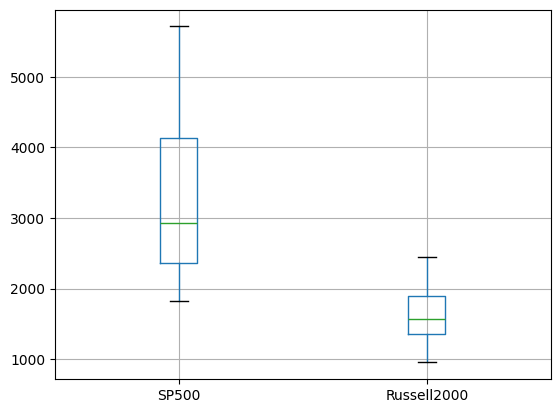

In [7]:
# Quick summary to check for outliers
print(prices.describe())

# Alternatively, use boxplot to visually identify outliers
import matplotlib.pyplot as plt
prices.boxplot()
plt.show()


The SP500 data seems to be skewed, let us further investigate the distribution using histogram.

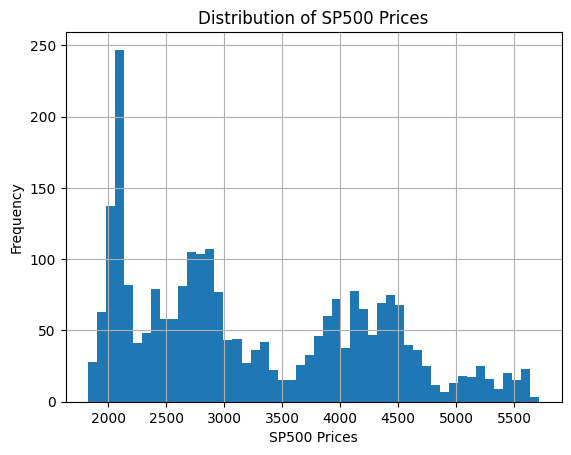

In [8]:
# Plot histogram for SP500
prices['SP500'].hist(bins=50)
plt.title('Distribution of SP500 Prices')
plt.xlabel('SP500 Prices')
plt.ylabel('Frequency')
plt.show()

It seems here we have a multimodal distribution for the SP500 dataset. In finance, this could happen when different market regimes (e.g., bull markets, bear markets, corrections, etc.) are present in the dataset. Each market regime might have its own behavior, leading to multiple peaks in the data.

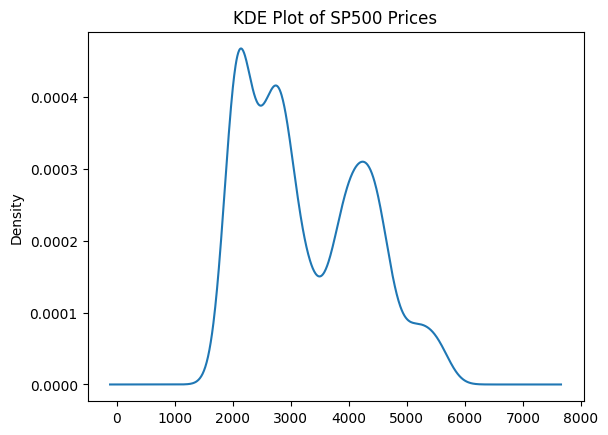

In [9]:
# Kernel density estimate (KDE) plot to see the multimodal distribution
prices['SP500'].plot(kind='kde', title='KDE Plot of SP500 Prices')
plt.show()


Given the observations above, we can fit a Gaussian Mixture Model (GMM). The GMM will allow you to estimate the parameters (mean and variance) of each underlying normal distribution.